In [348]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
import re
import json
from sklearn.model_selection import train_test_split
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

# DATASET EXPLORATION AND SPLIT

## Humicroedit and Funlines

In [375]:
data_main = pd.read_csv('data/humicroedit/task_1_all/train.csv')
data_funlines = pd.read_csv('data/humicroedit/task_1_all/train_funlines.csv')
humi = pd.concat([data_main, data_funlines])
humi = humi.drop_duplicates()
humi['len'] = [len(i.split(' ')) for i in humi['original']]
humi.head(2)

,id,original,edit,grades,meanGrade,len
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,15
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,17


In [351]:
humi['scaled_mean'] = humi.meanGrade/3

In [352]:
sum(humi['scaled_mean']<=0.5)

13180

Reviews are judged by variable number of people, and humor is subjective. We want to have some measure of how sure we are in the judgements. Paper notes that each headline had 5 judges.

In [353]:
grades = humi.grades.astype(str).str.split('')
std_list = np.zeros(len(grades))
for i,g in enumerate(grades):
    g = g[1:][:-1]
    g = list(map(int, g))
    std_list[i] = np.std(g)
humi['score_std'] = std_list

Text(0, 0.5, 'Standard deviation')

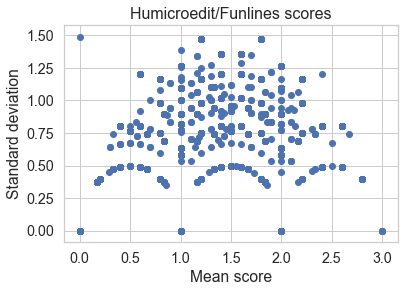

In [361]:
plt.scatter(humi.meanGrade, humi.score_std)
plt.title('Humicroedit/Funlines scores', size = 16)
plt.xlabel('Mean score')
plt.ylabel('Standard deviation')

Text(0.5, 0, 'Standard deviation of scores')

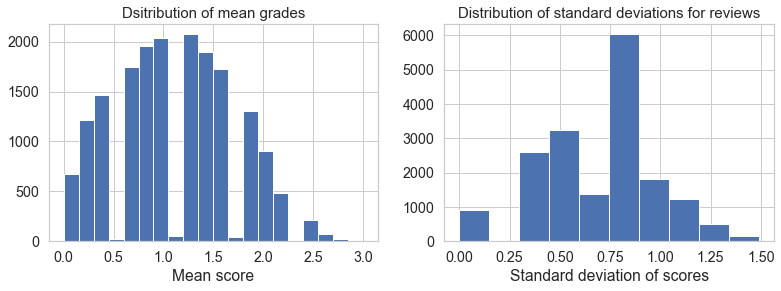

In [363]:
fig, axs = plt.subplots(1, 2, figsize = (13,4))
axs[0].hist(humi.meanGrade, bins=20)
axs[0].set_title('Dsitribution of mean grades', size = 15)
axs[0].set_xlabel('Mean score')
axs[1].hist(humi.score_std)
axs[1].set_title('Distribution of standard deviations for reviews', size = 15)
axs[1].set_xlabel('Standard deviation of scores')

The most dissagreement is on the "medium funny jokes", in the range from 1 to 2. Let's look at some eaxmples of jokes with 0 scores, jokes in 1-2 range and mean above 2.5

In [298]:
humi[humi.meanGrade==0].head(33)

,id,original,edit,grades,meanGrade,len,scaled_mean,score_std
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,11,0.0,0.0
9,14191,Dutch minister resigns in drug baron <row/>,blow,0,0.0,8,0.0,0.0
46,11660,Jared Kushner is the Real <President/>,Enemy,0,0.0,7,0.0,0.0
51,7008,Las Vegas <professor/> tells students Donald Trump incites violence after mass shooting,casino,0,0.0,12,0.0,0.0
61,827,New Orleans takes down 1st of 4 Confederate <statues/>,birds,0,0.0,10,0.0,0.0
111,10008,"U.S. BERNIE SANDERS MIRRORS TRUMP , BLAMES HILLARY CLINTON FOR NOT COMBATTING RUSSIAN <MEDDLING/> , DENIES IT HELPED HIS CAMPAIGN",Stealing,0,0.0,20,0.0,0.0
139,7863,<Watch/> : Conservative political advocate Matt Schlapp says Trump ’s ties to Russia are “ probably treasonous ”,clock,0,0.0,19,0.0,0.0
194,11417,Turkey protests : Erdogan accuses EU of <hypocrisy/>,lying,0,0.0,9,0.0,0.0
199,12814,United States tells WTO of concerns over <China/> 's new web access rules,library,0,0.0,13,0.0,0.0
220,2226,<Shooting/> at Great Mills High School in Maryland School Confirms,prom,0,0.0,11,0.0,0.0


In [295]:
humi[humi.meanGrade==1].head(25)

,id,original,edit,grades,meanGrade,len,scaled_mean,score_std
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,11,0.333333,0.894427
7,3731,"As Someone Who Grew Up Among Fundamentalist <Christians/> In The US , I 'm Surprised Anyone 's Surprised About Roy Moore",morons,21110,1.0,21,0.333333,0.632456
10,14268,Dozens dead in possible gas <attack/> in Syria ; regime denies allegation,bloating,22100,1.0,12,0.333333,0.894427
12,7614,Trump 's 2nd Nominee for <Army/> Secretary Withdraws,Class,22100,1.0,8,0.333333,0.894427
21,1415,Russian Trolls Would Love the ' Honest <Ads/> Act ',hotdogs,21110,1.0,10,0.333333,0.632456
23,10792,$ 2.7 billion Christmas <lottery/> in Spain [ Video ],cookies,21110,1.0,10,0.333333,0.632456
26,12583,Oregon : 20-Year-Old Sues Kroger for <Refusing/> to Sell Him Shotgun Shells,trying,22100,1.0,12,0.333333,0.894427
39,10636,TSA tightens electronics screening for domestic <flights/>,beers,11111,1.0,8,0.333333,0.000000
55,3795,Brazil 's Temer accused of passive <corruption/> by police,aggressiveness,32000,1.0,9,0.333333,1.264911
71,6487,Not even Trump can <control/> the GOP base,Afford,22100,1.0,8,0.333333,0.894427


In [236]:
humi[humi.meanGrade==3].head(5)

,id,original,edit,grades,meanGrade,len,score_std
1490,3404,"President Trump 's first year <anniversary/> report card , with grades from A + to F",Kindergarten,33333,3.0,16,0.0
6075,1229,Recent Scandals Highlight Trump 's Chaotic <Management/> Style,Fashion,33333,3.0,8,0.0
419,100419,Stormy Daniels on testifying to Congress : ' I have no fear of being under <oath/> ',politicians,33333,3.0,17,0.0
5115,105115,Sanders Says He Has More <Donors/> Than Trump,hair,33333,3.0,8,0.0


### Are hair jokes more funny? Are Trump jokes more funny?

Text(0.5, 0, 'mean score')

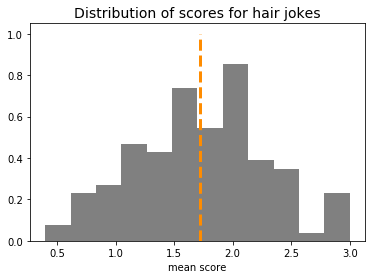

In [244]:
hair = humi[humi.edit.str.lower()=='hair'][['original', 'edit','meanGrade', 'score_std']]
plt.hist(hair.meanGrade, color='grey', bins=12, density=True)
plt.vlines(hair.meanGrade.mean(), ymin=0, ymax=1, color='darkorange', lw=3, ls='--')
plt.title('Distribution of scores for hair jokes', size=14)
plt.xlabel('mean score')

Text(0.5, 0, 'mean score')

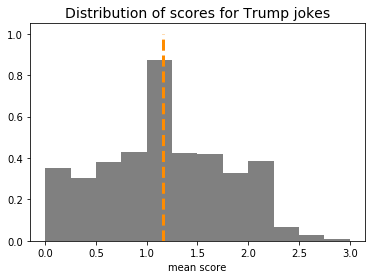

In [241]:
trump = humi[[('trump' in i) for i in humi.original.str.lower()]][['original', 'edit', 'meanGrade', 'score_std']]
plt.hist(trump.meanGrade, color='grey', bins=12, density=True)
plt.vlines(trump.meanGrade.mean(), ymin=0, ymax=1, color='darkorange', lw=3, ls='--')
plt.title('Distribution of scores for Trump jokes', size=14)
plt.xlabel('mean score')

## Prepare data

In [ ]:
"""
Functions for the Humicroedit/Funlines editing
"""
def replace_word(sentence, new_word):
    return re.sub('<(.*?)/>', new_word, sentence)

def drop_replacement_symbols(sentence):
    sentence = sentence.replace('<', '')
    return sentence.replace('/>', '')

def full_processing(row):
    return drop_replacement_symbols(replace_word(row.original, row.edit))

In [120]:
humi['text'] = [full_processing(row) for i,row in humi.iterrows()]
humi['label'] = [int(i>1.5) for i in humi.meanGrade]
original_list = [drop_replacement_symbols(i) for i in humi.original]
humi_jokes = humi[['text', 'meanGrade', 'score_std', 'label']]
humi_orig = pd.DataFrame({
    'text': original_list,
    'meanGrade': np.zeros(len(original_list)),
    'score_std': np.zeros(len(original_list)),
    'label': np.zeros(len(original_list))
})
humi_orig = humi_orig.drop_duplicates()
humi_dataset = pd.concat([humi_jokes, humi_orig], sort=False)
humi_dataset['scaled_mean'] = humi_dataset.meanGrade/3
humi_dataset = humi_dataset.sample(frac=1).reset_index(drop=True) #shuffle
#humi_dataset['text'] = humi_dataset['text'].astype('|S')
humi_dataset.head(3)

,text,meanGrade,score_std,label,scaled_mean
0,"Astros ' Jeff Luhnow , AJ Hinch fired for underwear stealing",1.8,0.4,1.0,0.6
1,France says no idea of Russian hacking Macron,0.6,0.8,0.0,0.2
2,Trump to Call Trade a Key Part of National Security,0.0,0.0,0.0,0.0


In [121]:
humi_dataset.to_csv('data/created_datasets/humi_funlines_all_train_upaired.csv', index=False)

In [302]:
humi_test = pd.read_csv('data/humicroedit/task_1_all/test_truth_task_1.csv')
humi_test = humi_test.drop('id', axis=1)
humi_test['text'] = [full_processing(row) for i,row in humi_test.iterrows()]
humi_test['score'] = humi_test.meanGrade/3
humi_test['label'] = ((humi_test.meanGrade/3)>=0.5).astype(int)
humi_test = humi_test[['text', 'score', 'label']]
humi_test = humi_test.sample(frac=1).reset_index(drop=True) #shuffle
humi_test.head()

,text,score,label
0,German parliament moves to partially cuddle the burka,0.200000,0
1,"Democrats : Americans want spoons , not ' saviors or handouts '",0.466667,0
2,A haunted psychologist started #immigrantexcellence to combat myth that immigrants and refugees are dangerous,0.133333,0
3,Sen. Jeff Flake : ' You ca n't eat to just remain silent ',0.533333,1
4,A Harvard psychologist started #immigrantexcellence to combat myth that immigrants and elves are dangerous,0.466667,0


In [142]:
humi_test.label.value_counts()

0    2479
1    545 
Name: label, dtype: int64

In [143]:
humi_test.to_csv('data/created_datasets/humi_funlines_test_replacements_unpaired.csv', index=False)

In [303]:
humi_dataset.label.value_counts()

0.0    24601
1.0    4720 
Name: label, dtype: int64

# Hashtag wars

In [107]:
hashtag_files_dir = 'data/hashtag_wars/train_dir/train_data/'
hashtag_files = os.listdir(hashtag_files_dir)
for i,f in enumerate(hashtag_files):
    try: 
        temp = pd.read_csv(hashtag_files_dir+f, sep='\t', header=None)
        temp['topic'] = f[:-4]
    except: pass
    if i==0: hashtag = temp
    else: hashtag = pd.concat([hashtag, temp], sort=False)

In [109]:
hashtag.columns = ['id', 'raw_text', 'score', 'topic']
hashtag.head(2)

,id,raw_text,score,topic
0,746395385170649088,Tony Hawk's Pro Mater #RuinAVideoGame @midnight,0,Ruin_A_Video_Game
1,746403973498822658,"@midnight @burnie @GavinFree @bdunkelman ""Silent Hills"" #RuinAVideoGame #FuckYouKonami",0,Ruin_A_Video_Game


In [110]:
#remove mentions and hashtags
hashtag['text'] = [' '.join(word for word in i.split(' ') if not (word.startswith('#') or word.startswith('@'))) for i in hashtag['raw_text']]

In [112]:
hashtag.head(2)

,id,raw_text,score,topic,text
0,746395385170649088,Tony Hawk's Pro Mater #RuinAVideoGame @midnight,0,Ruin_A_Video_Game,Tony Hawk's Pro Mater
1,746403973498822658,"@midnight @burnie @GavinFree @bdunkelman ""Silent Hills"" #RuinAVideoGame #FuckYouKonami",0,Ruin_A_Video_Game,"""Silent Hills"""


In [116]:
hashtag[hashtag.score==2]

,id,raw_text,score,topic,text
111,746183823784878081,@Midnight #PointsMe #RuinAVideoGame Halo by @Adele,2,Ruin_A_Video_Game,Halo by
103,712119303743516673,Voices in head made manifest #TwitterIn5Words @midnight,2,Twitter_In_5_Words,Voices in head made manifest
130,709589126274637825,Hubblegum #ScienceFoods @midnight,2,Science_Foods,Hubblegum
137,667201717956706304,Dat Ash Wednesday #SexyHolidays @midnight,2,Sexy_Holidays,Dat Ash Wednesday
79,653775535429038080,What exactly do you plan to do about joke theft on Twitter? @midnight #BetterDebateQuestions,2,Better_Debate_Questions,What exactly do you plan to do about joke theft on Twitter?
108,750549276737110017,#GotFiredBecause balls deep is not an acceptable answer when asked about my works progress. @midnight,2,Got_Fired_Because,balls deep is not an acceptable answer when asked about my works progress.
98,667576678223212544,"Still don't have kids, mom. @midnight #ThanksgivingIn5Words #PointsMe",2,Thanksgiving_In_5_Words,"Still don't have kids, mom."
18,649791075574530048,Andrew Slice Clay @midnight #Pizzalebrities,2,Pizzalebrities,Andrew Slice Clay
20,664545282881884161,#ScienceABook The Unbearable Lightness of Helium @midnight,2,Science_A_Book,The Unbearable Lightness of Helium
72,743284691390857216,Can't Touch This Thermostat #DadSongs @midnight,2,Dad_Songs,Can't Touch This Thermostat


Might not be very applicable as without topic they are not funny at all

# Crowdtruth

In [368]:
oneliners = pickle.load(open('data/crowdtruth/datasets/humorous_oneliners.pickle', 'rb'))

In [369]:
oneliners_len = np.array([len(i.split(' ')) for i in oneliners])

In [370]:
oneliners = np.array(oneliners)[oneliners_len<50]

In [371]:
len(oneliners)

5250

In [372]:
oneliners [0:10]

array(['Insanity is hereditary, - You get it from your children.',
       'An honest politician is one who, when bought, stays bought.',
       "You can tune a piano, but you can't tuna fish.",
       'A closed mouth gathers no foot.',
       "What's black and white and red all over?  An embarassed zebra.",
       "What's black and white and red all over?  Certainly not the Halifax newspapers.",
       "Gravity doesn't exist: the earth sucks.",
       "What's the most popular form of birth control?  The headache.",
       "He who laughs last probably doesn't understand the joke.",
       'Let him who takes the plunge remember to return it by Tuesday.'],
      dtype='<U822')

In [373]:
oneliners_df = pd.DataFrame({
    'text': oneliners,
    'label': np.zeros(len(oneliners))+1
})

In [376]:
oneliners_df.to_csv('data/created_datasets/humorous_oneliners_all.csv', index=False)

In [339]:
train, test = train_test_split(oneliners_df, test_size=0.2)
train.to_csv('data/created_datasets/humorous_oneliners_train.csv', index=False)
test.to_csv('data/created_datasets/humorous_oneliners_test.csv', index=False)

# Short jokes

In [377]:
short = pd.read_csv('data/short_jokes/shortjokes.csv')
short['label'] = np.zeros(short.shape[0])+1
short = short.drop('ID', axis=1)
short.columns = ['text', 'label']
short['len'] = [len(i.split(' ')) for i in short['text']]
short = short[short.len<=50]
short.head()

,text,label,len
0,"[me narrating a documentary about narrators] ""I can't hear what they're saying cuz I'm talking""",1.0,15
1,"Telling my daughter garlic is good for you. Good immune system and keeps pests away.Ticks, mosquitos, vampires... men.",1.0,18
2,I've been going through a really rough period at work this week It's my own fault for swapping my tampax for sand paper.,1.0,23
3,"If I could have dinner with anyone, dead or alive... ...I would choose alive. -B.J. Novak-",1.0,16
4,Two guys walk into a bar. The third guy ducks.,1.0,10


In [378]:
short.shape #231645

(231645, 3)

In [379]:
short = short.sample(frac=1).reset_index(drop=True)

In [380]:
short.to_csv('data/created_datasets/shortjokes_all.csv', index=False)

In [318]:
train, test = train_test_split(short, test_size=0.2)
train.to_csv('data/created_datasets/shortjokes_train.csv', index=False)
test.to_csv('data/created_datasets/shortjokes_test.csv', index=False)

# Joke dataset

In [179]:
wocka = json.load((open('data/joke_dataset/wocka.json')))
wocka_oneliners = [i['body'] for i in wocka if (i['category']=='One Liners')]
len(wocka_oneliners)

917

In [ ]:
stupid = json.load((open('data/joke_dataset/stupidstuff.json')))
stupid_oneliners_dict = [i for i in stupid if (i['category']=='One Liners')]
len(stupid_oneliners_dict)

Not a very good resource, not enough, and generally low quality

# Puns dataset
From Reddit Humor detection repository

In [381]:
puns.columns

Index(['text', 'label'], dtype='object')

In [382]:
puns = pd.read_csv('data/reddithumordetection/full_datasets/puns/puns_pos_neg_data.csv')
puns.columns = ['label', 'text']
puns = puns.replace(-1, 0)
puns['len'] = [len(i.split(' ')) for i in puns['text']]
puns = puns.sample(frac=1).reset_index(drop=True)
puns.head(3)

,label,text,len
0,1,the number 10210 is too intense,6
1,1,the best street for locating a gas station is fillmore avenue,11
2,0,Everyone stretches his legs according to the length of his coverlet,11


In [383]:
puns.label.value_counts()

1    2423
0    2403
Name: label, dtype: int64

In [384]:
puns.to_csv('data/created_datasets/puns_all.csv', index=False)

In [108]:
train, test = train_test_split(puns, test_size=0.2)
train.to_csv('data/created_datasets/puns_train.csv', index=False)
test.to_csv('data/created_datasets/puns_test.csv', index=False)

## Balancing with not-jokes datasets

### Crowdtruth data

In [155]:
proverbs = pickle.load(open('data/crowdtruth/datasets/proverbs.pickle', 'rb'))
proverbs_df = pd.DataFrame({
    'text': proverbs,
    'len': [len(i.split(' ')) for i in proverbs],
    'label': np.zeros(len(proverbs)),
    'source': ['proverbs' for i in range(len(proverbs))]
})
reuters = pickle.load(open('data/crowdtruth/datasets/reuters_headlines.pickle', 'rb'))
reuters_df = pd.DataFrame({
    'text': reuters,
    'len': [len(i.split(' ')) for i in reuters],
    'label': np.zeros(len(reuters)),
    'source': ['reuters' for i in range(len(reuters))]
})
wiki = pickle.load(open('data/crowdtruth/datasets/wiki_sentences.pickle', 'rb'), encoding='latin1')
wiki_df = pd.DataFrame({
    'text': wiki,
    'len': [len(i.split(' ')) for i in wiki],
    'label': np.zeros(len(wiki)),
    'source': ['wiki' for i in range(len(wiki))]
})

In [156]:
all_neg = pd.concat([proverbs_df, reuters_df, wiki_df])
all_neg = all_neg.sample(frac=1).reset_index(drop=True)
all_neg.to_csv('data/created_datasets/neutral_text.csv', index=False)
all_neg.head()

,text,len,label,source
0,China says 'really needs' South China Sea defenses in face of United States:,15,0.0,reuters
1,"They were married on May 29 , 1849 , and together had five children , only two of whom survived to adulthood , two died of typhoid and one of a brain tumor.",33,0.0,wiki
2,Greece says faced with crisis from cutbacks in migrant flows,11,0.0,reuters
3,The Great Gerbil is a large gerbil found throughout much of Central Asia.,13,0.0,wiki
4,"Outside of Europe , he conducted at the Metropolitan Opera in New York as well as the New York Philharmonic Orchestra.",21,0.0,wiki


In [300]:
all_neg.shape

(11513, 4)

### Add negatives

In [385]:
mill_news = pd.read_csv('data/million_news/abcnews-date-text.csv')
mill_news.head(2)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting licence
1,20030219,act fire witnesses must be aware of defamation


In [386]:
mill_news_200K = mill_news[-200000:].reset_index(drop=True)
mill_news_200K.head(2)

,publish_date,headline_text
0,20151016,australia names stars for international rules match against ire
1,20151016,australian survivor of msf kuduz attack outraged by inaction


In [387]:
mill_news_200K.publish_date[0]

20151016

In [388]:
mill_news_200K.publish_date.values[-1]

20191231

In [389]:
mill_news_200K = mill_news[-200000:].reset_index(drop=True)
mill_news_200K = mill_news_200K.drop('publish_date', axis=1)
mill_news_200K.columns = ['text']
mill_news_200K['label'] = np.zeros(mill_news_200K.shape[0])
mill_news_200K.head(2)

,text,label
0,australia names stars for international rules match against ire,0.0
1,australian survivor of msf kuduz attack outraged by inaction,0.0


In [390]:
mill_news_200K.to_csv('data/created_datasets/200K_million_news.csv', index=False)

Could use only sentences shorter than 35 from the Wiki sentences data.

# Dataset options

1. *basic* All together, with binary labels. For Humicroedit use only 'funny' versions. For balance add some news titles and/or quotes

2. *basic-weighted* All together, with added pre-set weights to funny jokes based on the dataset it was taken from. For Humicroedit use only 'funny' versions. For balance add some news titles and/or quotes

3. *humicroedit* Use only humicroedit, only original and replaced

4. *basic expanded* All together, humicroedit both funny and not, shuffled

## BASIC

In [260]:
humi = pd.read_csv('data/created_datasets/humi_funlines_all_train_upaired.csv')[['text', 'label']]
oneliners = pd.read_csv('data/created_datasets/humorous_oneliners_train.csv')[['text', 'label']]
puns = pd.read_csv('data/created_datasets/puns_train.csv')[['text', 'label']]
neutral = pd.read_csv('data/created_datasets/neutral_text.csv')[['text', 'label']]

all_together = pd.concat([humi, oneliners, puns, neutral]).sample(frac=1).reset_index(drop=True)
all_together.to_csv('data/created_datasets/basic_full_dataset_v1.csv')
all_together.head(3)

,text,label
0,Pakistani cricketers. They'll give you a run for your money.,1.0
1,"Former Trump spokeswoman was punished after top aide got her pregnant , lawsuit claims",0.0
2,The work on metal vases took on a new fullness : the artists competed among themselves with great virtuosity.,0.0


In [160]:
all_together.label.value_counts()

0.0    38032
1.0    10862
Name: label, dtype: int64

In [77]:
puns_test = pd.read_csv('data/reddithumordetection/data/puns/test.tsv')
puns_test.head(2)

,Unnamed: 0,text
0,0,i just got back from my vacation along the northern oregon coast and have i got astoria or two to tell you
1,1,when the money fell from my pocket i saw this punk reach for it pointed my 357 magnum at him and muttered go ahead take my pay


In [161]:
train, val = train_test_split(all_together, test_size=0.2)
train.to_csv('data/created_datasets/basic_full_dataset_v1_train.csv', index=False)
val.to_csv('data/created_datasets/basic_full_dataset_v1_validation.csv', index=False)

## BASIC EXPANDED

In [261]:
humi = pd.read_csv('data/created_datasets/humi_funlines_all_train_upaired.csv')[['text', 'label']]
oneliners = pd.read_csv('data/created_datasets/humorous_oneliners_train.csv')[['text', 'label']]
puns = pd.read_csv('data/created_datasets/puns_train.csv')[['text', 'label']]
short = pd.read_csv('data/created_datasets/shortjokes_train.csv')[['text', 'label']]
neutral = pd.read_csv('data/created_datasets/neutral_text.csv')[['text', 'label']]
neutralM8 = pd.read_csv('data/created_datasets/200K_million_news.csv')[['text', 'label']]

all_together = pd.concat([humi, oneliners, puns, short, neutral, neutralM8]).sample(frac=1).reset_index(drop=True)
all_together.to_csv('data/created_datasets/basic_expanded_v1.csv')
all_together.head(3)

,text,label
0,*posts Social Security number on social media* *hopes someone steals his identity and pays off his mortgage*,1.0
1,I went to the doctors the other day and asked if he had anything for wind. So he gave me a kite.,1.0
2,harvey retires from afl football after 432 north melbourne games,0.0


In [262]:
all_together.to_csv('data/created_datasets/basic_expanded_v1.csv')
train, val = train_test_split(all_together, test_size=0.2)
train.to_csv('data/created_datasets/basic_expanded_v1_train.csv', index=False)
val.to_csv('data/created_datasets/basic_expanded_v1_validation.csv', index=False)

## BASIC WEIGHTED

In [264]:
humi = pd.read_csv('data/created_datasets/humi_funlines_all_train_upaired.csv')[['text', 'label']]
oneliners = pd.read_csv('data/created_datasets/humorous_oneliners_train.csv')[['text', 'label']]
puns = pd.read_csv('data/created_datasets/puns_train.csv')[['text', 'label']]
neutral = pd.read_csv('data/created_datasets/neutral_text.csv')[['text', 'label']]
short = pd.read_csv('data/created_datasets/shortjokes_train.csv')
short['weight'] = 0.3
short = short.drop('len', axis=1)
short.columns = ['text', 'label', 'weight']

In [265]:
short.sample(frac=1).reset_index(drop=True).head(5)

,text,label,weight
0,"An old gambling buddy told me this joke: What did the man with premature ejaculation say to his blind wife? ""Honey, could you pass me the remote?"" Bet you didn't see THAT coming!",1.0,0.3
1,Life teachings Q: What do you call it when your child teaches you something they are interested in? A: Learning from your mistakes.,1.0,0.3
2,What do you do when you're attacked by a group of clowns? Go for the juggler,1.0,0.3
3,"""I want to get drunk in public."" ""Me too but on pancake batter."" ""If only there was a way to solve both problems."" -The Origin of Eggnog",1.0,0.3
4,When attacked by a mob of clowns... Go for the juggler.,1.0,0.3


Questionable jokes in the short jokes dataset, but maybe they will be useful to do soft training on. 

In [266]:
all_together = pd.concat([humi, oneliners, puns, neutral])
all_together['weight'] = 1
all_together = pd.concat([all_together, short.sample(frac=1).reset_index(drop=True)])
all_together = all_together.sample(frac=1).reset_index(drop=True)

In [267]:
all_together.sample(frac=1).reset_index(drop=True).head()

,text,label,weight
0,I'm responsible for 84% of all cat videos currently available on YouTube.,1.0,0.3
1,Trump deletes tweets in support of Luther Strange after Strange ’s loss,0.0,1.0
2,If you take a dump on a leaf You will have a shitty thyme,1.0,0.3
3,Netflix Accused Of Funnelling $ 430M Of International toys Into Tax Havens,0.0,1.0
4,"Ho ho ho! But that's enough about the Kardashians, merry Christmas everyone!",1.0,0.3


In [268]:
all_together.label.value_counts()

1.0    196178
0.0    38032 
Name: label, dtype: int64

In [243]:
all_together.to_csv('data/created_datasets/basic_weighted_v3.csv')
train, val = train_test_split(all_together, test_size=0.2)
train.to_csv('data/created_datasets/basic_weighted_v3_train.csv', index=False)
val.to_csv('data/created_datasets/basic_weighted_v3_validation.csv', index=False)

In [269]:
neutralM8 = pd.read_csv('data/created_datasets/200K_million_news.csv')[['text', 'label']]
all_together = pd.concat([humi, oneliners, puns, neutral, neutralM8])
all_together['weight'] = 1
all_together = pd.concat([all_together, short.sample(frac=1).reset_index(drop=True)])
all_together = all_together.sample(frac=1).reset_index(drop=True)
all_together.sample(frac=1).reset_index(drop=True).head()

,text,label,weight
0,' No Way In or Out ' : Australians Are Fleeing to the Beach to Escape Deadly Wildfires,0.0,1.0
1,donald trump set to meet vladimir putin soon us russia summit,0.0,1.0
2,"Trump, Rubio likely targets in eighth Republican presidential debate",0.0,1.0
3,You must work at subway...cause you`re givin` me a foot long.,1.0,0.3
4,homemade gun found in toowoomba raid,0.0,1.0


In [270]:
all_together.label.value_counts()

0.0    238032
1.0    196178
Name: label, dtype: int64

In [271]:
all_together.to_csv('data/created_datasets/basic_weighted_v4.csv')
train, val = train_test_split(all_together, test_size=0.2)
train.to_csv('data/created_datasets/basic_weighted_v4_train.csv', index=False)
val.to_csv('data/created_datasets/basic_weighted_v4_validation.csv', index=False)

In [247]:
neutralM8 = pd.read_csv('data/created_datasets/200K_million_news.csv')
neutralM8.head()

,text,label
0,aba decides against community broadcasting licence,0.0
1,act fire witnesses must be aware of defamation,0.0
2,a g calls for infrastructure protection summit,0.0
3,air nz staff in aust strike for pay rise,0.0
4,air nz strike to affect australian travellers,0.0
